In [1]:
import os
os.chdir('/lustre/scratch/aylar/GSE131907/')
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [3]:
file_path = "GSE131907_Lung_Cancer_normalized_log2TPM_matrix.txt"

adata = sc.read_text(file_path, first_column_names=True)
adata= adata.T
print(adata)
print(adata.obs_names[:5])
print(adata.var_names[:5])
print(adata.X[:5, :5])


AnnData object with n_obs × n_vars = 208506 × 29634
Index(['AAACCTGAGAAACCGC_LN_05', 'AAACCTGAGAAACGCC_NS_13',
       'AAACCTGAGAAGGTGA_LUNG_N18', 'AAACCTGAGACAAAGG_LUNG_N18',
       'AAACCTGAGACATAAC_LN_04'],
      dtype='object')
Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1'], dtype='object')
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [6]:
annotation_path = "GSE131907_Lung_Cancer_cell_annotation.txt"  
annotations = pd.read_csv(annotation_path, sep="\t", index_col=0)
annotations.head()

,Barcode,Sample,Sample_Origin,Cell_type,Cell_type.refined,Cell_subtype
Index,,,,,,
AAACCTGCAAGGTGTG_LUNG_N01,AAACCTGCAAGGTGTG,LUNG_N01,nLung,Myeloid cells,Myeloid cells,mo-Mac
AACTCCCGTTCACCTC_LUNG_N01,AACTCCCGTTCACCTC,LUNG_N01,nLung,Myeloid cells,Myeloid cells,mo-Mac
AACTCCCTCACGCGGT_LUNG_N01,AACTCCCTCACGCGGT,LUNG_N01,nLung,Myeloid cells,Myeloid cells,mo-Mac
AAGGAGCGTGTGCGTC_LUNG_N01,AAGGAGCGTGTGCGTC,LUNG_N01,nLung,Myeloid cells,Myeloid cells,mo-Mac
AAGGTTCAGGTACTCT_LUNG_N01,AAGGTTCAGGTACTCT,LUNG_N01,nLung,Myeloid cells,Myeloid cells,mo-Mac


In [7]:
annotations = annotations.loc[adata.obs_names]  
adata.obs = annotations
adata.obs.head()


,Barcode,Sample,Sample_Origin,Cell_type,Cell_type.refined,Cell_subtype
AAACCTGAGAAACCGC_LN_05,AAACCTGAGAAACCGC,LN_05,nLN,B lymphocytes,B lymphocytes,MALT B cells
AAACCTGAGAAACGCC_NS_13,AAACCTGAGAAACGCC,NS_13,mBrain,Epithelial cells,Epithelial cells,Malignant cells
AAACCTGAGAAGGTGA_LUNG_N18,AAACCTGAGAAGGTGA,LUNG_N18,nLung,T lymphocytes,T/NK cells,CD4+ Th
AAACCTGAGACAAAGG_LUNG_N18,AAACCTGAGACAAAGG,LUNG_N18,nLung,Myeloid cells,Myeloid cells,Monocytes
AAACCTGAGACATAAC_LN_04,AAACCTGAGACATAAC,LN_04,nLN,T lymphocytes,T/NK cells,Naive CD4+ T


In [8]:
# Step 1: QC - Exclude cells with < 500 expressed genes
adata.obs['n_genes'] = np.count_nonzero(adata.X, axis=1).flatten()
adata = adata[adata.obs['n_genes'] > 500, :]
# Step 2: QC - Exclude cells with > 20% UMIs of mitochondrial genes
# Identify mitochondrial genes (assuming they start with "MT-")
mito_genes = [gene for gene in adata.var_names if gene.startswith('MT-')]
adata.obs['total_counts'] = np.array(adata.X.sum(axis=1)).flatten()  # Total counts per cell
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / adata.obs['total_counts']
adata = adata[adata.obs['percent_mito'] < 0.2, :]  # Filter cells with > 20% mitochondrial genes
# Step 3: QC - Exclude cells with > 50% UMIs of ribosomal genes
# Identify ribosomal genes (assuming they start with "RPS" or "RPL")
ribosomal_genes = [gene for gene in adata.var_names if gene.startswith('RPS') or gene.startswith('RPL')]
adata.obs['percent_ribo'] = np.sum(adata[:, ribosomal_genes].X, axis=1) / adata.obs['total_counts']
adata = adata[adata.obs['percent_ribo'] < 0.5, :]

In [9]:
adata.write('QC_GSE131907.h5ad')

In [ ]:
adata=sc.read('QC_GSE131907.h5ad')

In [10]:
# Normalize total counts to 10,000 per cell
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat')

marker_genes = ["EPCAM", "COL1A1", "VWF", "CD3E", "CD79A", "MS4A1", "IGHG1",
               "CSF3R", "LYZ", "FGFBP2", "KIT", "LILRA4", "MKI67","PTPRC",
                "C1orf194","RSPH1", "C9orf24", "CAPS", "TPPP3", "SLPI",
                "SCGB1A1","SCGB3A1", "MSMB", "BPIFB1", "GJB6", "MYH11", 
                "AL365357.1", "SERPINB9", "IL1R2","SPARCL1", "NAPSA", "SCGB3A2",
                "SFTPB", "SFTPA1","SFTPA2", "SMC4", "ARL6IP1","CENPF","TPX2", 
                "TOP2A", "DUT","RRM2","HIST1H2BJ","TYMS", "PCNA","IGKC","MT2A",
                "S100A9","KRT81","S100P","PI3","KLK10","LY6G6C","CEACAM5","KRT16",
                "NDUFA4L2","AKR1B10","NMRAL2P","ALDH3A1", "DST",'EPCAM', 'KRT19',
                'CDH1', 'KRT18', 'CD3D', 'CD3E', 'CD3G', 'TRAC', 'CD79A', 'IGHM', 
                'IGHG3', 'IGHA2', 'CD68', 'MARCO', 'FCGR3A', 'LYZ', 'NCAM1', 'NKG7',
                'GNLY', 'KLRD1', 'KIT', 'MS4A2', 'GATA2', 'DCN', 'COL1A1', 'COL1A2', 
                'THY1', 'PECAM1', 'CLDN5', 'FLT1', 'RAMP2', 'OLIG1', 'OLIG2', 'MOG', 'CLDN11']
# Identify missing marker genes
missing_markers = [gene for gene in marker_genes if gene not in adata.var_names]
if missing_markers:
    print(f"Warning: The following marker genes are not in the dataset and will be ignored:\n{missing_markers}")

# Ensure marker genes are retained in HVGs
adata.var["highly_variable"] = adata.var["highly_variable"] | adata.var_names.isin(marker_genes)

# Subset the AnnData object to keep only highly variable genes (including forced markers)
adata = adata[:, adata.var["highly_variable"]]

# Verify which marker genes were successfully retained
retained_markers = [gene for gene in marker_genes if gene in adata.var_names]
print(f"Retained marker genes: {len(retained_markers)} / {len(marker_genes)}")
print(retained_markers)


['AL365357.1', 'NMRAL2P']
Retained marker genes: 93 / 95
['EPCAM', 'COL1A1', 'VWF', 'CD3E', 'CD79A', 'MS4A1', 'IGHG1', 'CSF3R', 'LYZ', 'FGFBP2', 'KIT', 'LILRA4', 'MKI67', 'PTPRC', 'C1orf194', 'RSPH1', 'C9orf24', 'CAPS', 'TPPP3', 'SLPI', 'SCGB1A1', 'SCGB3A1', 'MSMB', 'BPIFB1', 'GJB6', 'MYH11', 'SERPINB9', 'IL1R2', 'SPARCL1', 'NAPSA', 'SCGB3A2', 'SFTPB', 'SFTPA1', 'SFTPA2', 'SMC4', 'ARL6IP1', 'CENPF', 'TPX2', 'TOP2A', 'DUT', 'RRM2', 'HIST1H2BJ', 'TYMS', 'PCNA', 'IGKC', 'MT2A', 'S100A9', 'KRT81', 'S100P', 'PI3', 'KLK10', 'LY6G6C', 'CEACAM5', 'KRT16', 'NDUFA4L2', 'AKR1B10', 'ALDH3A1', 'DST', 'EPCAM', 'KRT19', 'CDH1', 'KRT18', 'CD3D', 'CD3E', 'CD3G', 'TRAC', 'CD79A', 'IGHM', 'IGHG3', 'IGHA2', 'CD68', 'MARCO', 'FCGR3A', 'LYZ', 'NCAM1', 'NKG7', 'GNLY', 'KLRD1', 'KIT', 'MS4A2', 'GATA2', 'DCN', 'COL1A1', 'COL1A2', 'THY1', 'PECAM1', 'CLDN5', 'FLT1', 'RAMP2', 'OLIG1', 'OLIG2', 'MOG', 'CLDN11']


In [11]:
# PCA & neighbors
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)
sc.tl.umap(adata)

In [12]:
sc.tl.leiden(adata, resolution=0.1)
# Count total Leiden clusters
num_clusters = len(adata.obs['leiden'].unique())
print(f"Number of Leiden clusters: {num_clusters}")

Number of Leiden clusters: 11


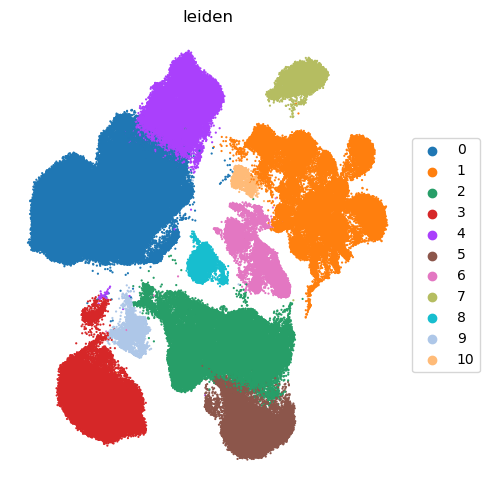

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))  # Set figure size
sc.pl.umap(adata, color="leiden", size=10, frameon=False, ax=ax, show=False)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("leiden_GSE131907.png", dpi=300)
plt.show()

In [15]:
adata.write("leiden_GSE131907.h5ad")

In [31]:
adata=sc.read("leiden_GSE131907.h5ad")

In [32]:
adata = adata[adata.obs['Sample_Origin'].isin(['nLung', 'tLung', 'tL/B']), :]

sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='seurat')

marker_genes = ["EPCAM", "COL1A1", "VWF", "CD3E", "CD79A", "MS4A1", "IGHG1",
               "CSF3R", "LYZ", "FGFBP2", "KIT", "LILRA4", "MKI67","PTPRC",
                "C1orf194","RSPH1", "C9orf24", "CAPS", "TPPP3", "SLPI",
                "SCGB1A1","SCGB3A1", "MSMB", "BPIFB1", "GJB6", "MYH11", 
                "AL365357.1", "SERPINB9", "IL1R2","SPARCL1", "NAPSA", "SCGB3A2",
                "SFTPB", "SFTPA1","SFTPA2", "SMC4", "ARL6IP1","CENPF","TPX2", 
                "TOP2A", "DUT","RRM2","HIST1H2BJ","TYMS", "PCNA","IGKC","MT2A",
                "S100A9","KRT81","S100P","PI3","KLK10","LY6G6C","CEACAM5","KRT16",
                "NDUFA4L2","AKR1B10","NMRAL2P","ALDH3A1", "DST", 'EPCAM', 'KRT19',
                'CDH1', 'KRT18', 'CD3D', 'CD3E', 'CD3G', 'TRAC', 'CD79A', 'IGHM', 
                'IGHG3', 'IGHA2', 'CD68', 'MARCO', 'FCGR3A', 'LYZ', 'NCAM1', 'NKG7',
                'GNLY', 'KLRD1', 'KIT', 'MS4A2', 'GATA2', 'DCN', 'COL1A1', 'COL1A2', 
                'THY1', 'PECAM1', 'CLDN5', 'FLT1', 'RAMP2', 'OLIG1', 'OLIG2', 'MOG', 'CLDN11']

# Identify missing marker genes
missing_markers = [gene for gene in marker_epi if gene not in adata.var_names]
if missing_markers:
    print(f"Warning: The following marker genes are not in the dataset and will be ignored:\n{missing_markers}")

# Ensure marker genes are retained in HVGs
adata.var["highly_variable"] = adata.var["highly_variable"] | adata.var_names.isin(marker_epi)

# Subset the AnnData object to keep only highly variable genes (including forced markers)
adata = adata[:, adata.var["highly_variable"]]

# Verify which marker genes were successfully retained
retained_markers = [gene for gene in marker_epi if gene in adata.var_names]
print(f"Retained marker genes: {len(retained_markers)} / {len(marker_epi)}")
print(retained_markers)

['AL365357.1', 'NMRAL2P']
Retained marker genes: 48 / 50
['C1orf194', 'RSPH1', 'C9orf24', 'CAPS', 'TPPP3', 'SLPI', 'SCGB1A1', 'SCGB3A1', 'MSMB', 'BPIFB1', 'GJB6', 'MYH11', 'SERPINB9', 'IL1R2', 'SPARCL1', 'NAPSA', 'SCGB3A2', 'SFTPB', 'SFTPA1', 'SFTPA2', 'SMC4', 'ARL6IP1', 'CENPF', 'TPX2', 'TOP2A', 'DUT', 'RRM2', 'HIST1H2BJ', 'TYMS', 'PCNA', 'IGKC', 'MT2A', 'S100A9', 'KRT81', 'S100P', 'PI3', 'KLK10', 'LY6G6C', 'CEACAM5', 'KRT16', 'NDUFA4L2', 'AKR1B10', 'ALDH3A1', 'DST', 'EPCAM', 'KRT19', 'KRT18', 'CDH1']


In [33]:
sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata)

In [34]:
sc.tl.leiden(adata, resolution=0.15)
num_clusters = len(adata.obs['leiden'].unique())
print(f"Number of Leiden clusters: {num_clusters}")

Number of Leiden clusters: 10


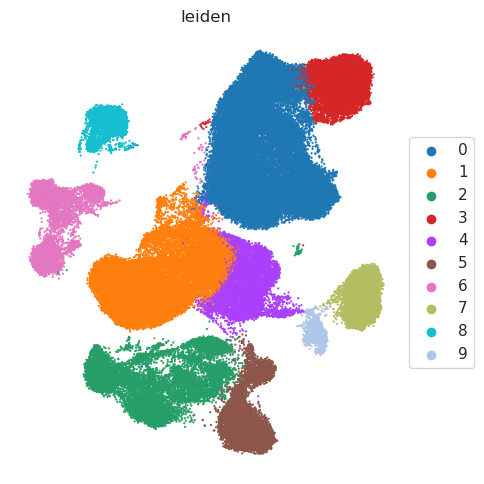

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))  # Set figure size
sc.pl.umap(adata, color="leiden", size=10, frameon=False, ax=ax, show=False)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("leiden_NTB_GSE131907.png", dpi=300)
plt.show()

In [36]:
adata.write("leiden_NTB_GSE131907.h5ad")

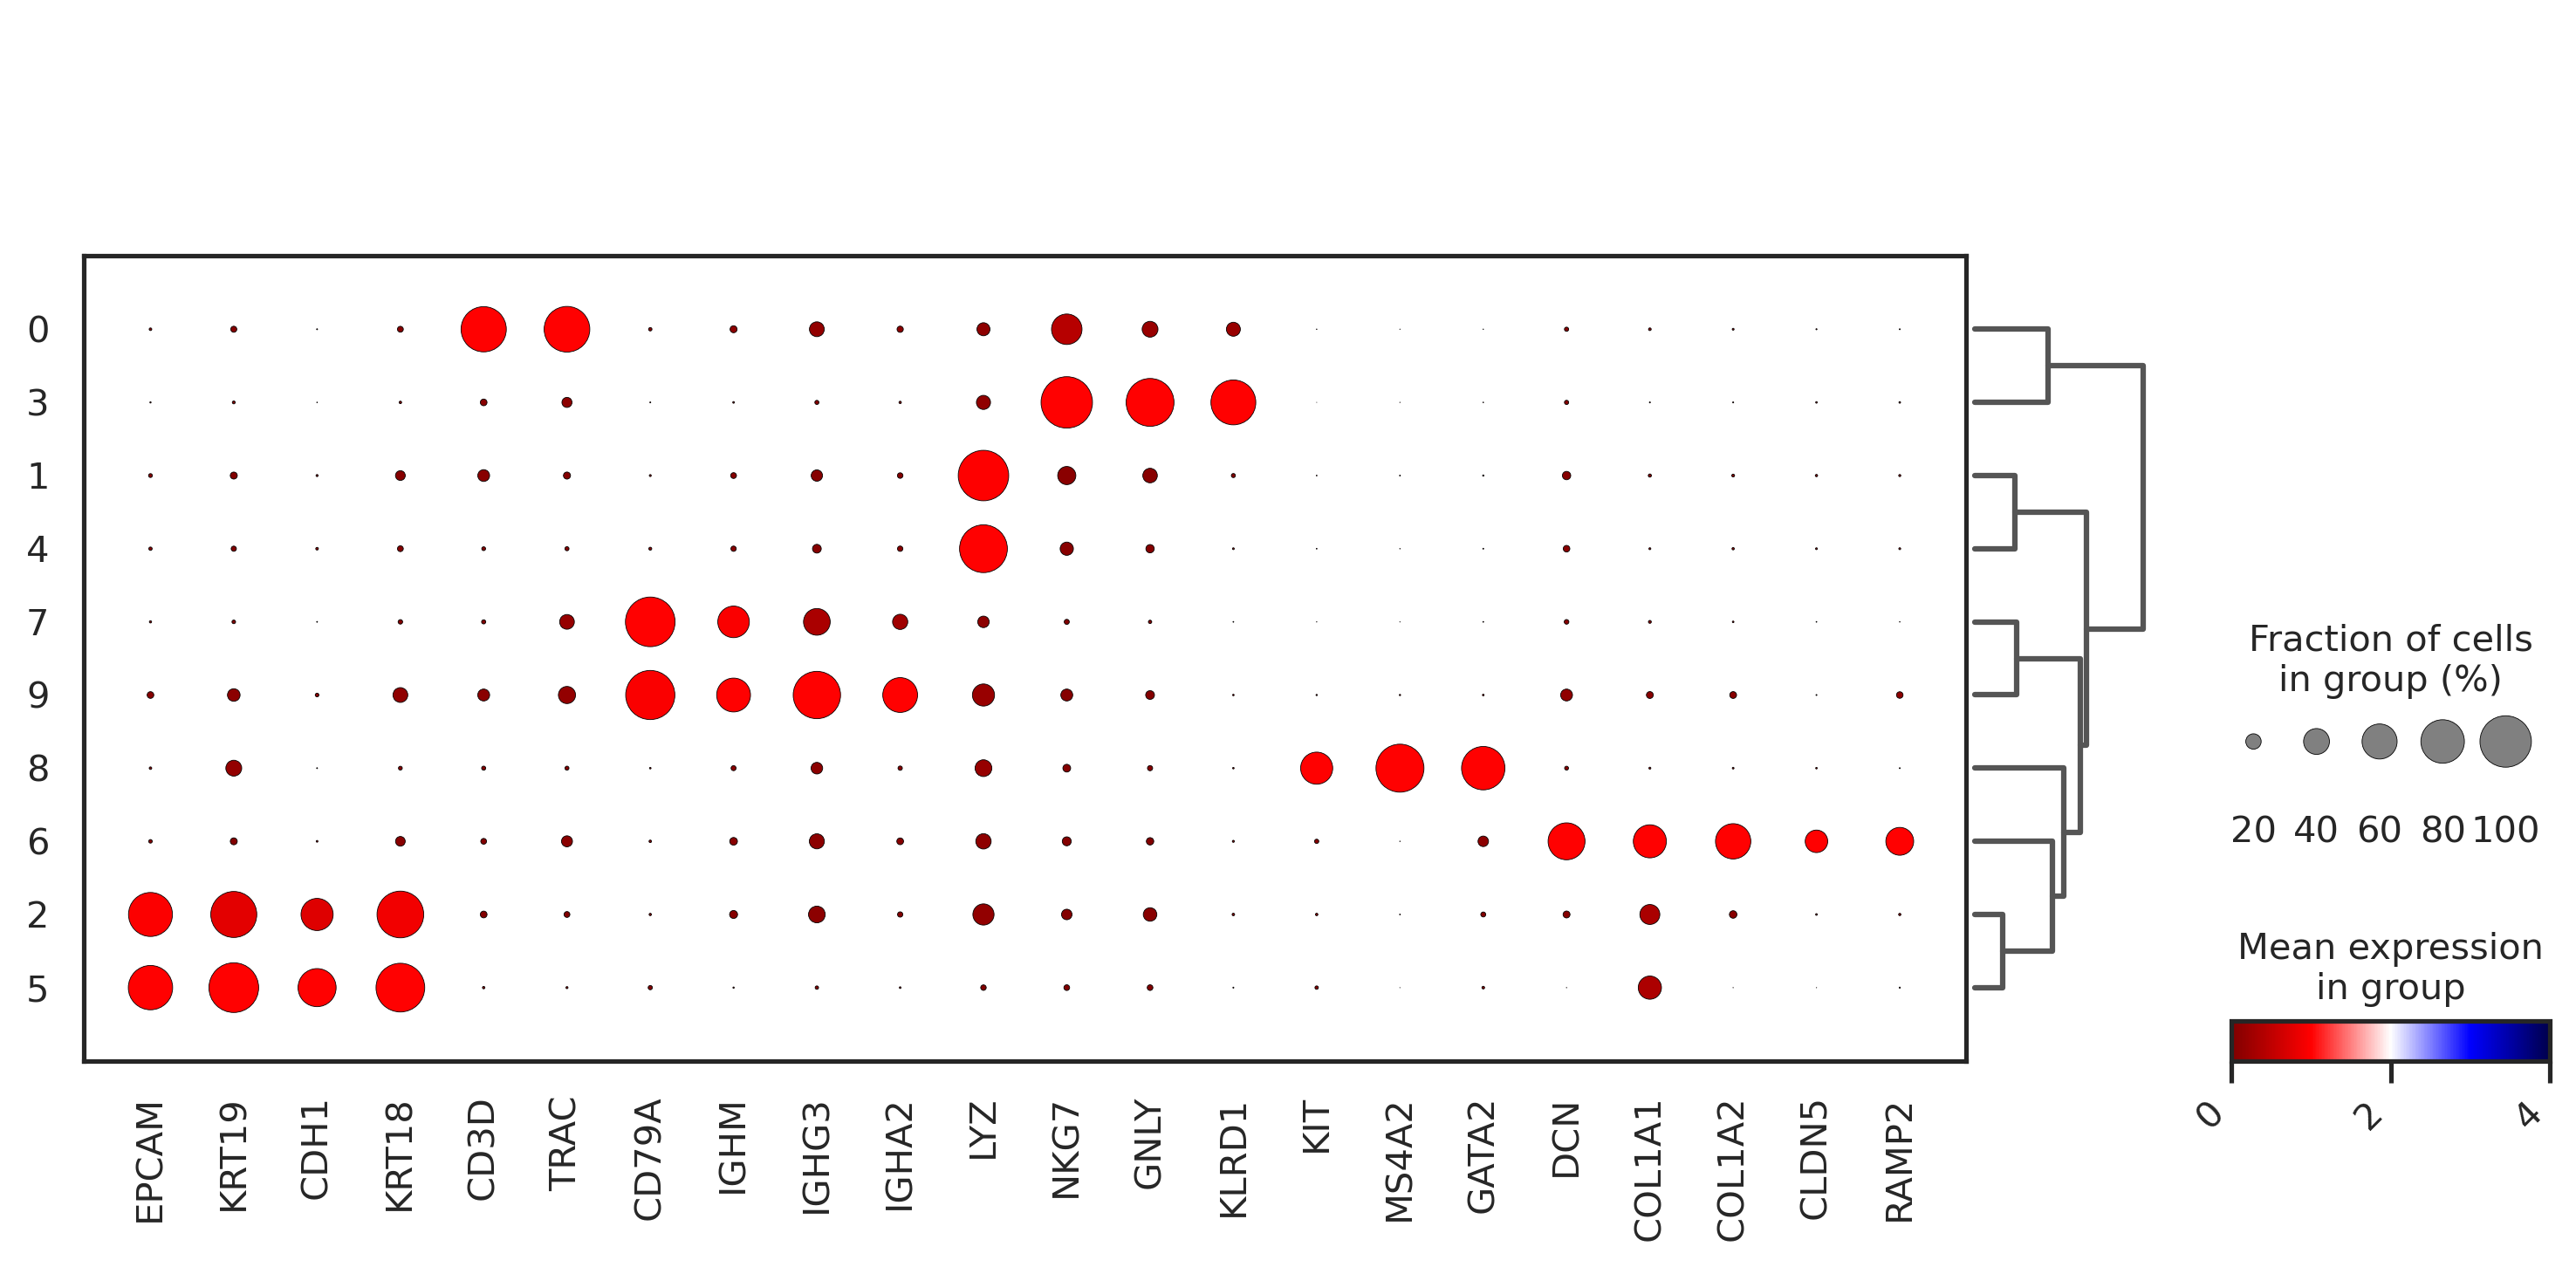

In [37]:
marker_genes = [
    'EPCAM', 'KRT19', 'CDH1', 'KRT18', 'CD3D', 'CD3E', 'CD3G', 'TRAC', 
    'CD79A', 'IGHM', 'IGHG3', 'IGHA2', 'CD68', 'MARCO', 'FCGR3A', 'LYZ', 
    'NCAM1', 'NKG7', 'GNLY', 'KLRD1', 'KIT', 'MS4A2', 'GATA2', 'DCN', 
    'COL1A1', 'COL1A2', 'THY1', 'PECAM1', 'CLDN5', 'FLT1', 'RAMP2', 
    'OLIG1', 'OLIG2', 'MOG', 'CLDN11'
]
marker= [gene for gene in marker_genes if gene in adata.var_names]
sns.set_theme(style='white', font_scale=1) 
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sc.tl.dendrogram(adata,groupby='leiden')
sc.pl.dotplot(adata,  marker, groupby='leiden', dendrogram=True,  log=False, swap_axes=False,  vmax=4,  ax=ax, 
    cmap="seismic_r",   standard_scale="var",  show=False)
 
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12) 
plt.tight_layout()
plt.savefig("dotplot2_suptype.png", dpi=300)
plt.show()

In [38]:
adata.obs.columns

Index(['Barcode', 'Sample', 'Sample_Origin', 'Cell_type', 'Cell_type.refined',
       'Cell_subtype', 'n_genes', 'total_counts', 'percent_mito',
       'percent_ribo', 'leiden'],
      dtype='object')

In [39]:
adata.obs["Cell_type"].unique

<bound method Series.unique of AAACCTGAGAAGGTGA_LUNG_N18       T lymphocytes
AAACCTGAGACAAAGG_LUNG_N18       Myeloid cells
AAACCTGAGACCTTTG_LUNG_N30       T lymphocytes
AAACCTGAGACGACGT_LUNG_T09       Myeloid cells
AAACCTGAGACGACGT_LUNG_T34       B lymphocytes
                                   ...       
TTTGTCATCTTACCGC_EBUS_49        T lymphocytes
TTTGTCATCTTGCCGT_LUNG_T30    Epithelial cells
TTTGTCATCTTTACAC_LUNG_N20          MAST cells
TTTGTCATCTTTACAC_LUNG_T25       B lymphocytes
TTTGTCATCTTTAGGG_LUNG_T31    Epithelial cells
Name: Cell_type, Length: 98573, dtype: category
Categories (8, object): ['B lymphocytes', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'MAST cells', 'Myeloid cells', 'NK cells', 'T lymphocytes']>